In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import os
from glob import glob
import numpy as np
import torch
import torchvision
from torchvision.io import read_video

import skimage.io as io
import PIL.Image
from IPython.display import Image 


from helpers import CPU, CUDA, clip, GPT2Tokenizer
from helpers import ClipCaptionModel, generate2, generate_beam

from show import show_single_image, set_latex_fonts, show_multiple_images

# set_latex_fonts(usetex=False)

In [5]:
# Download the model weights

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')

pretrained_model = 'COCO'  # @param ['COCO', 'Conceptual captions']
file_id = {
    "Conceptual captions": "14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT",
    "COCO": "1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX",
}.get(pretrained_model)
file_dst = model_path

if not os.path.exists(model_path):
    print("Downloading the model weights...")
    !gdown --id $file_id -O $file_dst
    print("Model weights downloaded successfully.")
else:
    print(f"Model weights downloaded already at {model_path}.")

/home/pbagad/install/miniconda3/envs/clip/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX
To: /home/pbagad/projects/CLIP_prefix_caption-video/pretrained_models/model_wieghts.pt
100%|█████████████████████████████████████████| 636M/636M [00:05<00:00, 114MB/s]
Model weights downloaded successfully.


In [6]:
# Set the device
is_gpu = True
device = CUDA(0) if is_gpu else "cpu"

In [7]:
# Load CLIP model and GPT tokenizer
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
# Load captioning model and load weights
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval()
model = model.to(device)

### Load videos from ActivityNet-Captions dataset

In [10]:
from os.path import join, exists, basename
from glob import glob
import json
import numpy as np

In [11]:
# load caption annotations

data_root = "/home/pbagad/fiftyone/"
dataset = "activitynet-captions"

split = "val_1"


split_file = join(data_root, dataset, split + ".json")
assert exists(split_file)

split_info = json.load(open(split_file, "rb"))

In [14]:
# load videos from ActivityNet

dataset = "activitynet-100"
split = "validation"

video_dir = join(data_root, dataset, split, "data")
videos = glob(join(video_dir, "*.mp4"))
video_ids = list(map(lambda x: basename(x).split(".mp4")[0], videos))

avail_video_ids = list(set(video_ids).intersection(set(split_info.keys())))

print("Number of videos: ", len(avail_video_ids))

Number of videos:  119


In [73]:
# load clip and its caption

np.random.seed(100)
sample_id = avail_video_ids[np.random.randint(len(avail_video_ids))]
video_path = join(video_dir, sample_id + ".mp4")
assert exists(video_path)

video_anno = split_info[sample_id]

vframes, _, metadata = read_video(video_path)

# extract clip from the video
fps = metadata["video_fps"]

# sample first clip from annotations
clip_index = 2
clip_start_in_sec, clip_end_in_sec = video_anno["timestamps"][clip_index]
clip_start_frame = int(clip_start_in_sec * fps)
clip_end_frame = int(clip_end_in_sec * fps)

clip_caption = video_anno["sentences"][clip_index]

clip_frames = vframes[clip_start_frame:clip_end_frame,...]

# sample specific frames from clip to be shown
num_frames_selected = 8
idx_frames_selected = np.linspace(0, len(clip_frames) - 1, num_frames_selected, dtype=int)
clip_frames_selected = clip_frames[idx_frames_selected]

In [74]:
clip_caption

' They then begin to dance, twirling and swirling and leaning against each other.'

In [75]:
clip_frames_selected.shape

torch.Size([8, 352, 480, 3])

In [76]:
def generate_caption_per_frame(clip_frames, use_beam_search=False):
    """
    
    Args:
        clip_frames (List[PIL.Image]): frames in the clip
    """
    generated_captions = []
    for pil_image in clip_frames:

        image = preprocess(pil_image).unsqueeze(0).to(device)
        with torch.no_grad():
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        if use_beam_search:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
        else:
            generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

        generated_captions.append(generated_text_prefix)
    
    return generated_captions

In [77]:
clip_frames_pil = [PIL.Image.fromarray(x.numpy()) for x in clip_frames_selected]

In [78]:
clip_caption_per_frame = generate_caption_per_frame(clip_frames_pil)

100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


In [79]:
clip_caption_per_frame

['A man and woman standing in a room.',
 'A man and woman standing in a doorway.',
 'A woman standing next to a man in a restaurant.',
 'A man and woman are standing next to each other.',
 'A woman is looking at a man in a mirror.',
 'A person is standing in a room with a table.',
 'A beautiful woman standing next to a man in a room.',
 'A man and woman standing next to each other.']

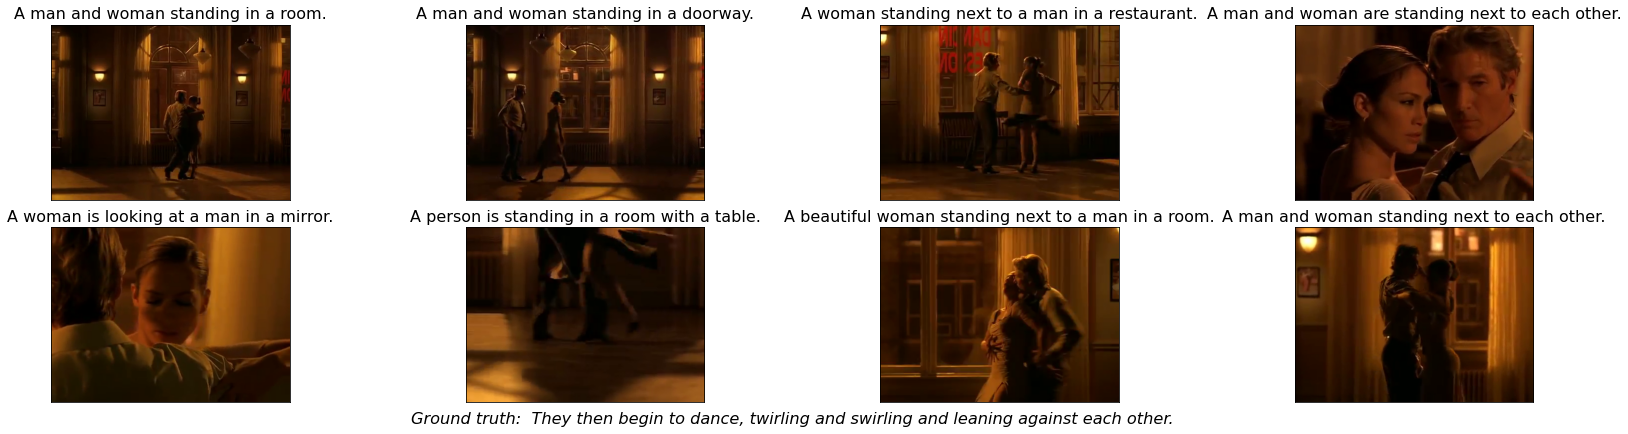

In [82]:
show_multiple_images(
    clip_frames_selected,
    n_cols=len(clip_caption_per_frame) // 2,
    subtitles=clip_caption_per_frame,
    title="",
    caption=f"Ground truth: {clip_caption}",
    figsize=(23, 6),
)